In [1]:
import os
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
import matplotlib.pyplot as plt
from src import render_model_gym
from datetime import datetime
import importlib
from src import render_model_gym

from src import helpers
from src.definitions import PROJECT_ROOT, enforce_absolute_path

import src.lucy_classes_v1 as lucy

importlib.reload(lucy)

<module 'src.lucy_classes_v1' from 'c:\\GitHub\\training-lucy\\src\\lucy_classes_v1.py'>

In [2]:
# Configuration
n_envs = 7
xml_path = enforce_absolute_path("animals/lucy_v2.xml")


def new_vec_env(env: lucy.LucyEnv, monitor_dir: str):
    return make_vec_env(
        env,
        n_envs=n_envs,
        vec_env_cls=SubprocVecEnv,
        monitor_dir=monitor_dir,
    )


print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(
    f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators"
)
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

sim_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
log_dir = f"logs/lucy_v1_standing_{sim_start_time}/"
os.makedirs(log_dir, exist_ok=True)
print(f"Standing log directory: {log_dir}")

MuJoCo version: 3.4.0
Lucy model loaded: 53 qpos dims, 44 qvel dims, 38 actuators
Observation space will be: 95 dims (qpos[2:] + qvel)
Standing log directory: logs/lucy_v1_standing_2026-01-10_18-04/


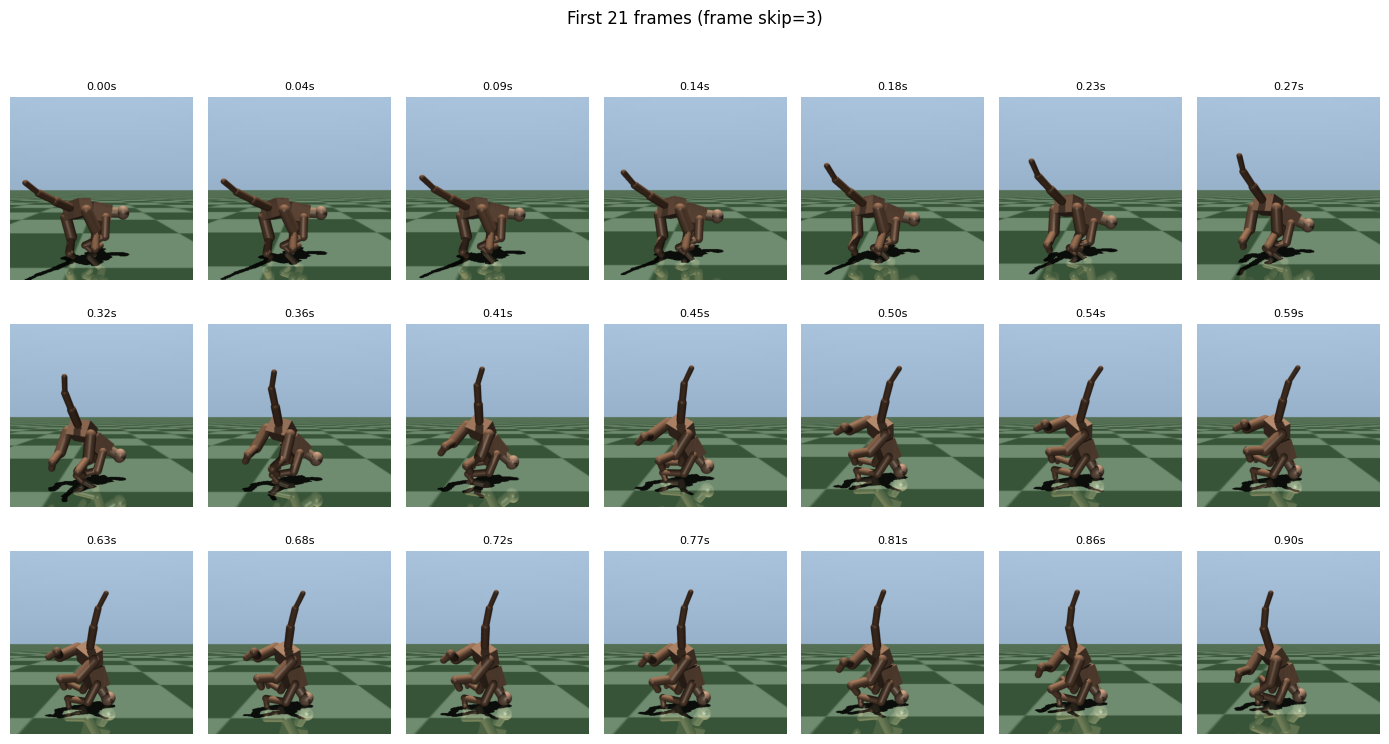

,time,chest_height,forward_velocity,total_height_reward,head_direction_reward,leg_pos_reward,straight_tail_reward,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.045,0.193352,0.081321,1.130968e-16,0.105474,0.503994,-0.022422,2.122782,6.366013
2,0.090,0.188527,0.196692,5.741430e-17,0.104883,0.504830,-0.182171,1.923523,12.321860
3,0.135,0.177957,0.306788,4.810587e-19,0.102955,0.502865,-0.102799,-0.028512,16.405899
4,0.180,0.173548,0.275623,2.502421e-17,0.103878,0.494270,-0.035997,0.001434,16.402041
5,0.225,0.167943,0.234056,1.181791e-16,0.107807,0.482711,-0.015723,1.982317,18.220998
6,0.270,0.167400,0.191691,4.942268e-13,0.089084,0.462495,-0.113557,1.796969,23.785319
7,0.315,0.164346,0.194698,5.143955e-10,0.055479,0.429935,-0.041826,1.741032,29.109668
8,0.360,0.158568,0.232780,1.691677e-08,0.020527,0.389981,-0.006223,1.635397,33.965311
9,0.405,0.150130,0.291864,1.943194e-08,0.000000,0.347683,-0.017698,1.471339,38.494290


In [3]:
importlib.reload(lucy)


def make_env(render_mode="None", *args, **kwargs):
    return lucy.LucyStandingWrapper(
        lucy.LucyEnv(
            xml_file=xml_path, render_mode=render_mode, max_episode_seconds=10
        ),
    )

standing_attrs = [
    "chest_height",
    "forward_velocity",
    "total_height_reward",
    "head_direction_reward",
    "leg_pos_reward",
    "straight_tail_reward",
]

env = make_env(render_mode="rgb_array")

df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=standing_attrs,
)
plt.show()
df

In [4]:
standing_vec_env = new_vec_env(make_env, log_dir)


standing_vec_env = VecMonitor(standing_vec_env, log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {log_dir}")


standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=3,
    gamma=0.99,
    gae_lambda=0.9,
    clip_range=0.2,
    ent_coef=0.05,
    learning_rate=3e-4,
    target_kl=0.05,
    policy_kwargs=dict(
        net_arch=dict(
            pi=[512, 512, 512, 256], vf=[512, 512, 512, 256]
        )  # Larger network
    ),
)
# train for nigger delete.
# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 10_000_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


Created 7 parallel standing environments
Logging to: logs/lucy_v1_standing_2026-01-10_18-04/
Using cpu device
Training standing policy for 10,000,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 71.2     |
|    ep_rew_mean     | -40.3    |
| time/              |          |
|    fps             | 3270     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 96.2        |
|    ep_rew_mean          | -58.2       |
| time/                   |             |
|    fps                  | 2775        |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.017992059 |
|    clip_fraction        | 0.26   

In [5]:
standing_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v2_standing_model_{sim_start_time}"
)
standing_model.save(standing_model_path)
print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-10_18-04


In [6]:
importlib.reload(render_model_gym)
#render_model_gym.render_model_gym(standing_model_path, xml_path)

<module 'src.render_model_gym' from 'c:\\GitHub\\training-lucy\\src\\render_model_gym.py'>

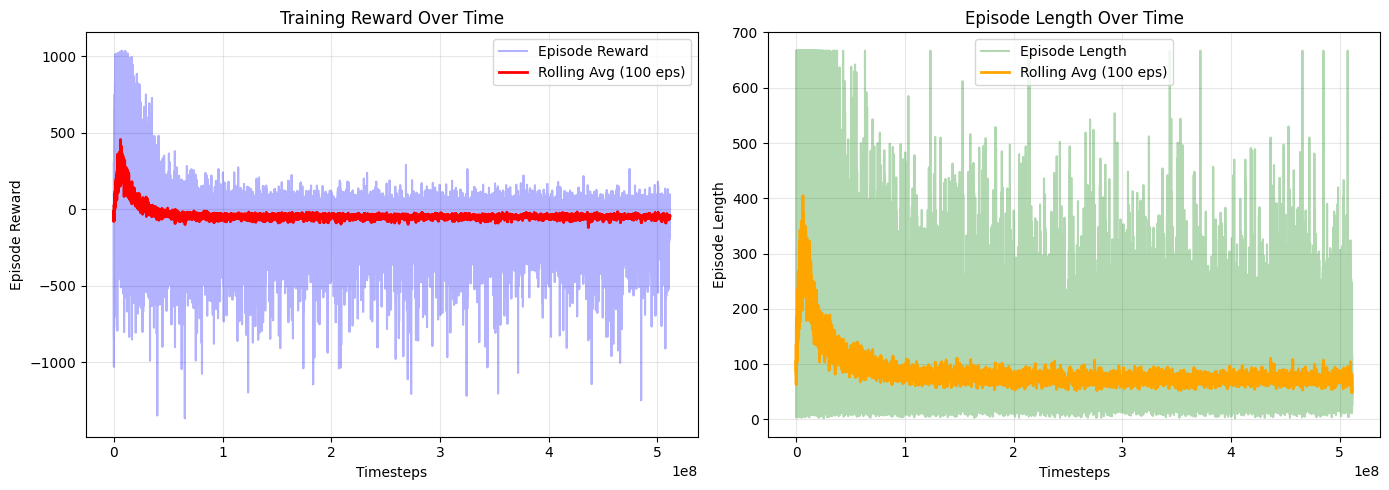

Training Summary:
Total episodes: 192514
Final avg reward (last 100 eps): -41.82
Max reward: 1037.35
  Final avg length (last 100 eps): 70.9


In [7]:
standing_df = load_results(log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

# Walking training

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
C:\Users\326po\AppData\Local\Temp\ipykernel_23176\4216077184.py:6: SyntaxWarning: invalid escape sequence '\G'
  "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"


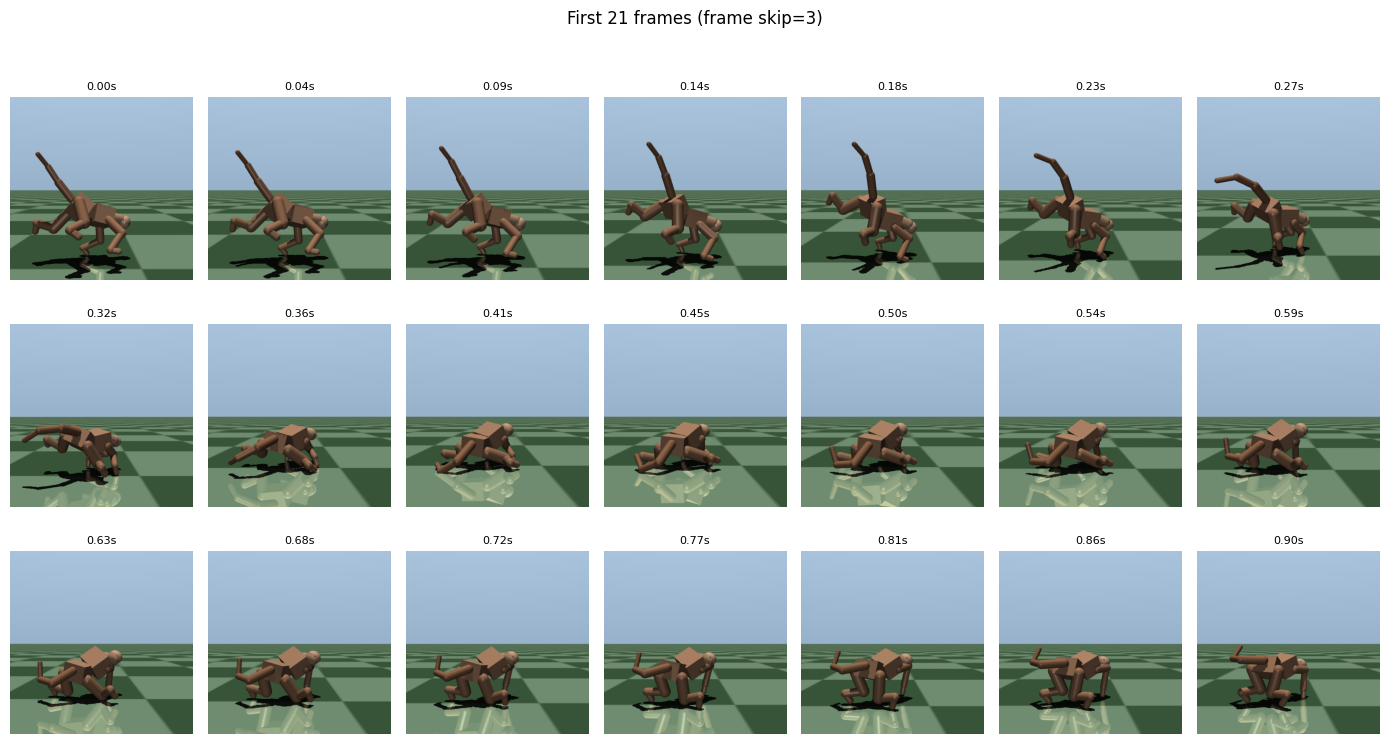

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.045,0.197523,-0.051095,-0.049060,0.0,-0.099386,0.051774,"{'chest': {'height': 0.1975229637313008, 'rewa...",0.823375,2.492569
2,0.090,0.193627,-0.094053,-0.066169,0.0,-0.024764,0.050908,"{'chest': {'height': 0.19362715913284498, 'rew...",0.814940,4.946397
3,0.135,0.184954,-0.131403,-0.056991,0.0,-0.006229,0.048668,"{'chest': {'height': 0.18495444905138944, 'rew...",0.814818,7.381557
4,0.180,0.173484,-0.111960,-0.169922,0.0,-0.022881,0.043861,"{'chest': {'height': 0.17348403534543336, 'rew...",0.699350,9.777489
5,0.225,0.174253,0.000598,-0.041529,0.0,-0.018759,0.042989,"{'chest': {'height': 0.17425296709756485, 'rew...",0.835502,12.063019
6,0.270,0.165711,-0.054621,0.029108,0.0,-0.003235,0.040010,"{'chest': {'height': 0.16571148873623046, 'rew...",0.916530,14.757512
7,0.315,0.150553,-0.161255,0.009296,0.0,-0.000892,0.034685,"{'chest': {'height': 0.1505534170987226, 'rewa...",0.874504,17.496533
8,0.360,0.128036,-0.504791,-0.245582,0.0,-0.000836,0.029457,"{'chest': {'height': 0.12803625852260586, 'rew...",0.600042,19.643759
9,0.405,0.128804,-0.330103,-0.309077,0.0,-0.021298,0.028031,"{'chest': {'height': 0.128803633598105, 'rewar...",-0.714238,17.918414


In [8]:
# Create walking training environment
importlib.reload(lucy)

if "standing_model_path" not in locals():
    standing_model_path = (
        "C:\GitHub\training-lucy\trained_models\lucy_v1_standing_model_2026-01-10_11-03"
    )

walking_attrKeys = [
    "chest_height",
    "forward_velocity",
    "forward_reward",
    "gait_reward",
    "stillness_reward",
    "leg_pos_reward",
    "height_dict"
]


walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)


def make_walking_env(render_mode="None"):
    """Factory function for walking environment."""
    env = lucy.LucyEnv(
        xml_file=xml_path,
        render_mode=render_mode,
        max_episode_seconds=30,
    )
    env = lucy.LucyWalkingWrapper(
        env,
        forward_weight=1.0,
        gait_weight=0.2,
        body_contact_penalty=-2.0,
        standing_reward_discount_factor=0.3,
    )
    return env


env = make_walking_env(render_mode="rgb_array")
model = PPO.load(standing_model_path, env=env)

# attach env so model.predict works
df = render_model_gym.display_test_env(
    env,
    max_frames=21,
    frame_skip=3,
    attr_keys=walking_attrKeys,
    model=model,
)
plt.show()
df

In [9]:
render_model_gym.parse_nested_columns(df, ["height_dict"])

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,reward,cum_reward,height_dict.chest.height,height_dict.chest.reward,height_dict.hips.height,height_dict.hips.reward,height_dict.head.height,height_dict.head.reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.045,0.197523,-0.051095,-0.049060,0.0,-0.099386,0.051774,0.823375,2.492569,0.197523,1.619991e-23,0.243003,4.572865e-04,0.172058,3.041517e-100
2,0.090,0.193627,-0.094053,-0.066169,0.0,-0.024764,0.050908,0.814940,4.946397,0.193627,3.292959e-25,0.244495,2.033595e-03,0.165392,3.872628e-103
3,0.135,0.184954,-0.131403,-0.056991,0.0,-0.006229,0.048668,0.814818,7.381557,0.184954,5.637365e-29,0.241964,1.617756e-04,0.152541,1.016346e-108
4,0.180,0.173484,-0.111960,-0.169922,0.0,-0.022881,0.043861,0.699350,9.777489,0.173484,5.882186e-34,0.233849,4.837505e-08,0.136850,1.558285e-115
5,0.225,0.174253,0.000598,-0.041529,0.0,-0.018759,0.042989,0.835502,12.063019,0.174253,1.269058e-33,0.226721,3.881714e-11,0.142234,3.395558e-113
6,0.270,0.165711,-0.054621,0.029108,0.0,-0.003235,0.040010,0.916530,14.757512,0.165711,2.477221e-37,0.202817,1.612985e-21,0.142185,3.233049e-113
7,0.315,0.150553,-0.161255,0.009296,0.0,-0.000892,0.034685,0.874504,17.496533,0.150553,6.469903e-44,0.163568,1.452887e-38,0.142674,5.270113e-113
8,0.360,0.128036,-0.504791,-0.245582,0.0,-0.000836,0.029457,0.600042,19.643759,0.128036,1.076019e-53,0.114395,6.405390e-60,0.138215,6.100436e-115
9,0.405,0.128804,-0.330103,-0.309077,0.0,-0.021298,0.028031,-0.714238,17.918414,0.128804,2.317858e-53,0.095599,4.398374e-68,0.150604,1.464508e-109


In [10]:
walking_vec_env = new_vec_env(make_walking_env, walking_log_dir)
print(f"Loading from standing model at: {standing_model_path}")


walking_model = PPO.load(standing_model_path, env=walking_vec_env)
walking_model.set_env(walking_vec_env)

walking_model.learn(total_timesteps=50_000_000)

Loading from standing model at: C:\GitHub\training-lucy\trained_models\lucy_v2_standing_model_2026-01-10_18-04
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 75.9     |
|    ep_rew_mean     | 21       |
| time/              |          |
|    fps             | 2725     |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 14336    |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 70.3         |
|    ep_rew_mean          | 20.4         |
| time/                   |              |
|    fps                  | 2538         |
|    iterations           | 2            |
|    time_elapsed         | 11           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0130288005 |
|    clip_fraction        | 0.0815       |
|    clip_range           | 0.2  

KeyboardInterrupt: 

In [11]:
walking_model_path = os.path.join(
    PROJECT_ROOT, "trained_models", f"lucy_v1_walking_model_{walking_start_time}"
)
walking_model.save(walking_model_path)

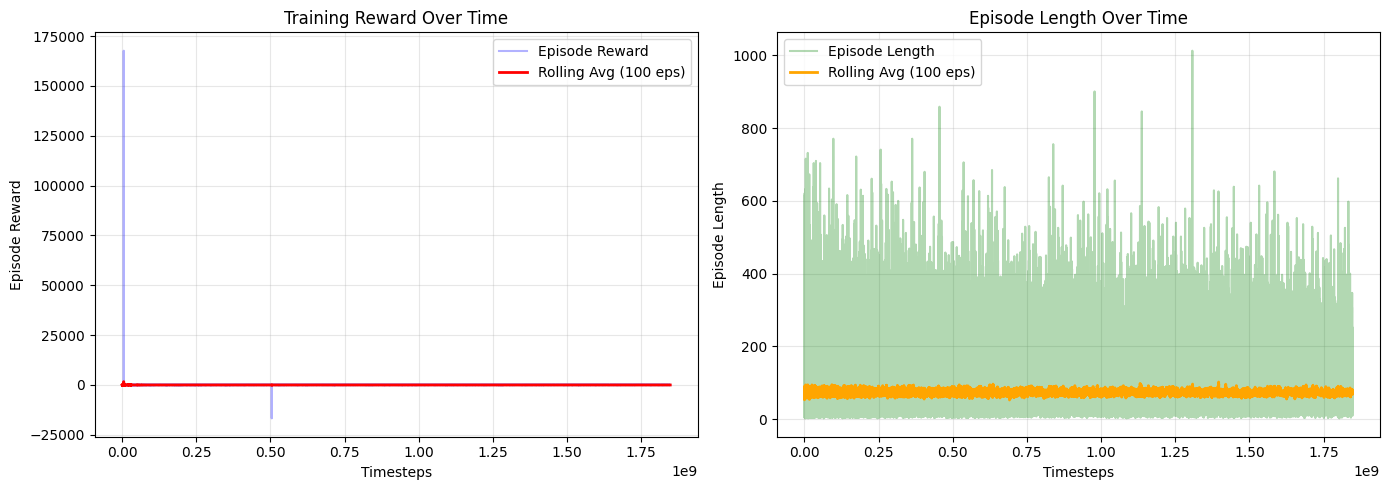

Training Summary:
Total episodes: 331204
Final avg reward (last 100 eps): 17.28
Max reward: 167693.50
  Final avg length (last 100 eps): 74.6


In [12]:
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode terminated during frame collection.


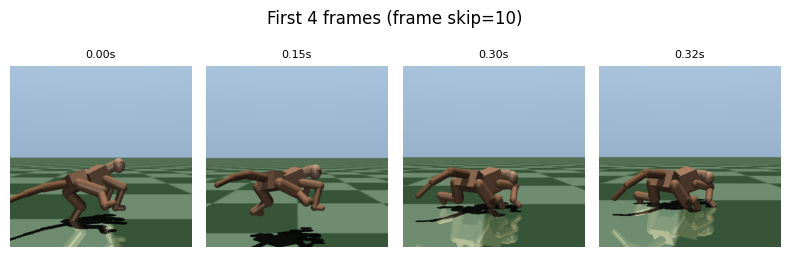

,time,chest_height,forward_velocity,forward_reward,gait_reward,stillness_reward,leg_pos_reward,height_dict,reward,cum_reward
0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN
1,0.150,0.264126,0.241098,0.141285,0.0,-0.205068,0.051582,"{'chest': {'height': 0.26412605642860615, 'rew...",1.410367,12.096113
2,0.300,0.127211,0.276289,0.173976,0.0,-0.014652,0.042106,"{'chest': {'height': 0.1272108440912085, 'rewa...",1.110224,23.727264
3,0.315,0.110735,0.288422,0.021527,0.0,-0.018268,0.040455,"{'chest': {'height': 0.1107346527748811, 'rewa...",-24.254395,-0.527131


In [14]:
model = PPO.load(walking_model_path, env=make_walking_env())
importlib.reload(render_model_gym)
df = render_model_gym.display_test_env(
    make_walking_env(render_mode="rgb_array"),
    max_frames=21,
    frame_skip=10,
    attr_keys=walking_attrKeys + ["leg_pos_reward"],
    model=model,
)
plt.show()
display(df)

In [15]:
render_model_gym.render_model_gym(walking_model_path, xml_path)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Simulation dt: 0.0150s per step
Running simulation at 1.0x speed... Close the window to exit.

Stopped by user
